### Understanding the Dataset 
The dataset consists of 150000 records and 11 features. Below are the 11 features and their descriptions.

|Feature|Description|
|-----|-----|
|SeriousDlqin2yrs|Person experienced 90 days past due delinquency or worse|
|RevolvingUtilizationOfUnsecuredLines| Total balance on credit cards and personal lines of credit|
|age| Age of borrower in years|
|NumberOfTime30-59DaysPastDueNotWorse| Number of times borrower has been 30-59 days past due but no worse in the last 2 years|
|DebtRatio| Monthly debt payments, alimony,living costs divided by monthy gross income|
|MonthlyIncome|Monthly Income|
|NumberOfOpenCreditLinesAndLoans| Number of Open loans (installment like car loan or mortgage) and Lines of credit|
|NumberOfTimes90DaysLate|Number of times borrower has been 90 days or more past due|
|NumberRealEstateLoansOrLines| Number of mortgage and real estate loans including home equity lines of credit|
|NumberOfTime60-89DaysPastDueNotWorse| Number of times borrower has been 60-89 days past due but no worse in the last 2 years|
|NumberOfDependents|Number of dependents in family excluding themselves|

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix,classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Task 1 :Load the data and get an overview of the data using `.describe()` and `.info()` method

In [3]:
df = pd.read_csv('fin_dataset.csv',index_col=0)

df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
print(df.describe())
print(df.info())

       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     150000.000000                         150000.000000  150000.000000   
mean           0.066840                              6.048438      52.295207   
std            0.249746                            249.755371      14.771866   
min            0.000000                              0.000000       0.000000   
25%            0.000000                              0.029867      41.000000   
50%            0.000000                              0.154181      52.000000   
75%            0.000000                              0.559046      63.000000   
max            1.000000                          50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         150000.000000  150000.000000   1.202690e+05   
mean                               0.421033     353.005076   6.670221e+03   
std                                4.192781    2

**There are null values in the variables `NumberOfDependents` and `MonthlyIncome`.**

### Task 2 : Check for the skewness in the variables in `NumberOfDependents`  and `MonthlyIncome` by plotting a histogram.

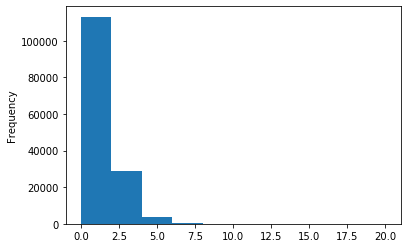

In [5]:
df['NumberOfDependents'].plot(kind='hist')

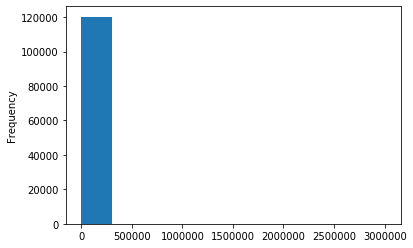

In [6]:
df['MonthlyIncome'].plot(kind='hist')

### Task 3 :There is skewness in the feature `NumberOfDependents`. So let's replace the null values in this feature with the median and let's do the same for the feature `MonthlyIncome`

In [7]:
df['NumberOfDependents']  = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())

df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(),inplace=True)

### Task 4: Check for the distribution of the target variable using a `countplot()`

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64


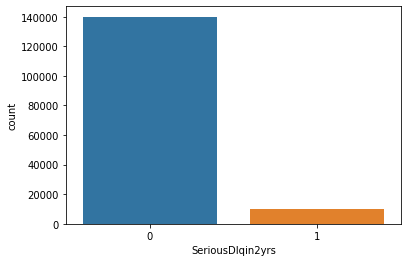

In [8]:
print(df['SeriousDlqin2yrs'].value_counts()/df['SeriousDlqin2yrs'].value_counts().sum())

sns.countplot(df['SeriousDlqin2yrs'],data=df)

### There is heavy imbalance in the target variable. We will deal with this imbalance using different techniques below

### Task 5 : Seperate the predictors and the target and split the data into training set and testing set. Keep the `test_size = 0.2` and the `random_state=42` 

In [9]:
target = 'SeriousDlqin2yrs'

X = df.loc[:,df.columns!=target]
Y = df.loc[:,df.columns==target]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

### Task 6 : For a better method of inference, let's check for the correlation between different features by plotting a heatmap. The basic rule of feature selection is that we need to select features which are highly correlated to the dependent variable and also not highly correlated with each other as they show the same trend. 

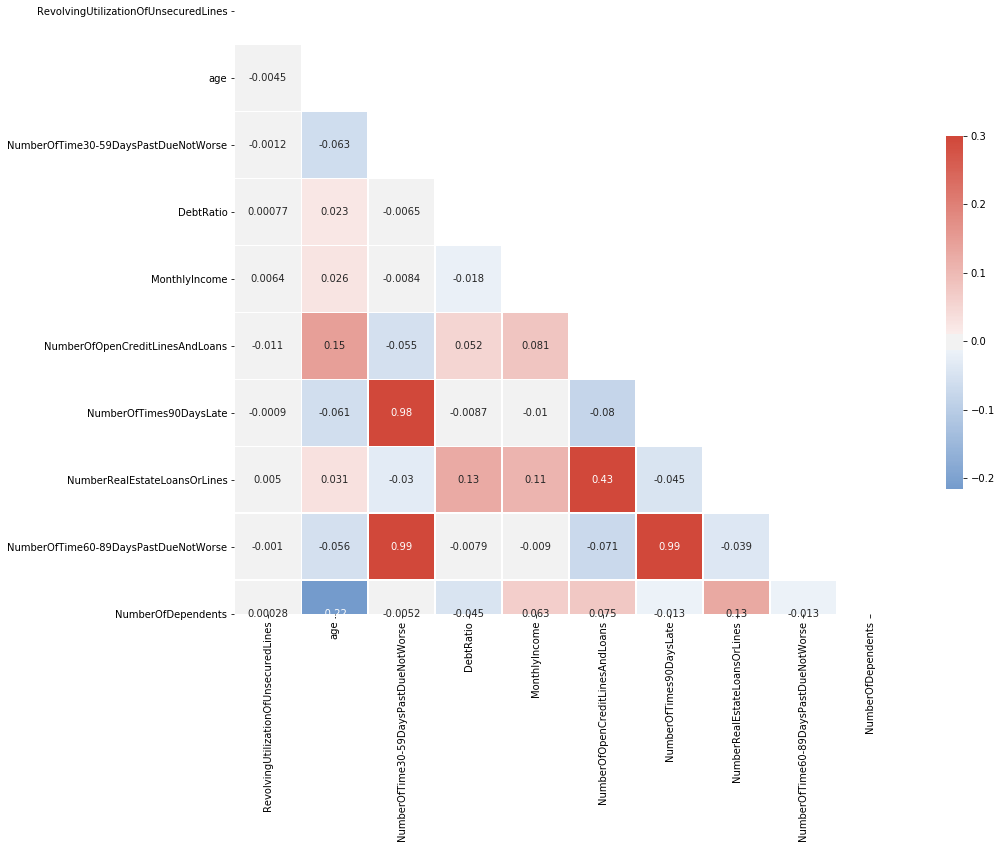

In [10]:
# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

### Task 7 : We can see that the features `NumberOfTime60-89DaysPastDueNotWorse` is highly correlated along with the features `NumberOfTime30-59DaysPastDueNotWorse` and `NumberOfTimes90DaysLate`. So let's drop the features `NumberOfTime60-89DaysPastDueNotWorse` and `NumberOfTime30-59DaysPastDueNotWorse` from the train as well as the test data

In [11]:
X_train.drop(['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse'],1,inplace=True)
X_test.drop(['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse'],1,inplace=True)

### Task 8 : Fit a vanilla Logistic Regression model on the training set and predict on the test set and plot the confusion matrix, accuracy, precision, recall and F1_score for the predicted model 

In [12]:
clf = LogisticRegression().fit(X_train, Y_train)

Y_test_pred = clf.predict(X_test)

print("Accuracy = " , accuracy_score(Y_test, Y_test_pred))
print("Precision = " ,precision_score(Y_test, Y_test_pred))
print("Recall = " ,recall_score(Y_test, Y_test_pred))
print("F1 Score = " ,f1_score(Y_test, Y_test_pred))

pd.crosstab(Y_test_pred, Y_test[target], rownames=['Predicted'], colnames=['Actual'])

Accuracy =  0.9349
Precision =  0.5283018867924528
Recall =  0.014314928425357873
F1 Score =  0.027874564459930314


Actual,0,1
Predicted,,
0,28019,1928
1,25,28


### The recall is low and this is because from the matrix above, we can see that the False Negatives are too many in the data. This was supposed to happen because since the target is highly imbalanced with lesser number of 1s, our model has learnt to predict only 0s most of the times. But as per our problem, we are more concerned with the occurence of a delinquency i.e with the prediction of 1s and not 0s. Hence we have to treat this class imbalance first

### Task 9 : Set the parameter `class_weight=balanced` inside Logistic Regression and check for the metrics calculated above and also the confusion matrix

In [13]:
clf = LogisticRegression(class_weight='balanced').fit(X_train, Y_train)

Y_test_pred_balanced = clf.predict(X_test)

print("Accuracy = " , accuracy_score(Y_test, Y_test_pred_balanced))
print("Precision = " ,precision_score(Y_test, Y_test_pred_balanced))
print("Recall = " ,recall_score(Y_test, Y_test_pred_balanced))
print("F1 Score = " ,f1_score(Y_test, Y_test_pred_balanced))

pd.crosstab(Y_test_pred_balanced, Y_test[target], rownames=['Predicted'], colnames=['Actual'])


Accuracy =  0.6890333333333334
Precision =  0.1251652262328419
Recall =  0.6293456032719836
F1 Score =  0.208803324569587


Actual,0,1
Predicted,,
0,19440,725
1,8604,1231


### We can see that the recall has increased from ~1.4% to ~63% by setting the `class_weight`, since the False Negatives have also reduced, but the Precision seems to have reduced. This is a trade-off, we have to accept. 

### By setting the class weights we got a decent recall score. But this may not be the case all the times. In such cases, will have to use other resampling methods like 
- Random Oversampling
- Random Undersampling
- Tomek Undersampling
- SMOTE 

### NOTE : All types of Undersampling and Oversampling techniques are always performed on the train data and not on the test data

### Task 10 : Perform Random Undersampling on the train data and then fit a Logistic regression model on this undersampled data and then predict on the test data and calculate the precision, recall, accuracy, f1-score and the confusion matrix.

In [14]:
from imblearn.under_sampling import RandomUnderSampler
#Code starts here

# Create random under sampler object
rus = RandomUnderSampler(random_state=0)

#Undersampling the train data
X_sample_1, y_sample_1 =  rus.fit_sample(X_train, Y_train)


#Initiating a logistic regression model
model_rus = LogisticRegression()

#Fitting the model with sampled data
model_rus.fit(X_sample_1, y_sample_1)

#Making prediction of test values
Y_pred=model_rus.predict(X_test)

# Calculating the necessary metrics
print("Accuracy = " , accuracy_score(Y_test, Y_pred))
print("Precision = " ,precision_score(Y_test, Y_pred))
print("Recall = " ,recall_score(Y_test, Y_pred))
print("F1 Score = " ,f1_score(Y_test, Y_pred))

#Finding the confusion matrix
pd.crosstab(Y_pred, Y_test[target], rownames=['Predicted'], colnames=['Actual'])

#Code ends here

Accuracy =  0.6792666666666667
Precision =  0.12310717797443461
Recall =  0.6400817995910021
F1 Score =  0.20649843311891805


Actual,0,1
Predicted,,
0,19126,704
1,8918,1252


### So Random Undersampling gives a slightly better recall than just setting class_weights as balanced. Let's now see how another undersampling method called Tomek Undersampling performs 

### Task 11 : Perform Tomek Undersampling on the train data and then fit a Logistic regression model on this undersampled data and then predict on the test data and calculate the precision, recall, accuracy, f1-score and the confusion matrix.

Accuracy =  0.9349
Precision =  0.5283018867924528
Recall =  0.014314928425357873
F1 Score =  0.027874564459930314


Actual,0,1
Predicted,,
0,28019,1928
1,25,28


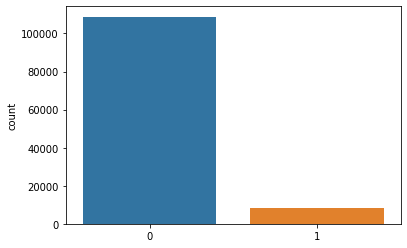

In [15]:

# Import package
from imblearn.under_sampling import TomekLinks

#Code starts here

#Initialising Tomek Links object
tl = TomekLinks()

#Undersamlpling the train data
X_sample4, y_sample4 = tl.fit_sample(X_train, Y_train)

# Plot the distribution of the target using a countplot
sns.countplot(y_sample4)

#Initialising the logistic regression model
model_tl = LogisticRegression()

#Fitting the model with sampled data
model_tl.fit(X_sample4, y_sample4)

#Making the predictions with test data
Y_pred_tomek=model_tl.predict(X_test)

# Calculating the necessary metrics
print("Accuracy = " , accuracy_score(Y_test, Y_pred_tomek))
print("Precision = " ,precision_score(Y_test, Y_pred_tomek))
print("Recall = " ,recall_score(Y_test, Y_pred_tomek))
print("F1 Score = " ,f1_score(Y_test, Y_pred_tomek))

#Finding the confusion matrix
pd.crosstab(Y_pred_tomek,Y_test[target],rownames=['Predicted'], colnames=['Actual'])

#Code ends here

### Tomek Undersampling doesn't seem a good fit for data. There is hardly any increase in recall compared to the vanilla model. Undersampling techniques, even if they provide an increase in the metric of choice, are not favoured since you tend to lose some information when you undersample the majority class of the target. Hence in most cases, what we prefer to perform are Oversampling techniques like Random Oversampling and SMOTE.

### Task 12 : Perform Random Oversampling on the train data and then fit a Logistic regression model on this undersampled data and then predict on the test data and calculate the precision, recall, accuracy, f1-score and the confusion matrix.

Accuracy =  0.7127333333333333
Precision =  0.1326643140714601
Recall =  0.6150306748466258
F1 Score =  0.2182510885341074


Actual,0,1
Predicted,,
0,20179,753
1,7865,1203


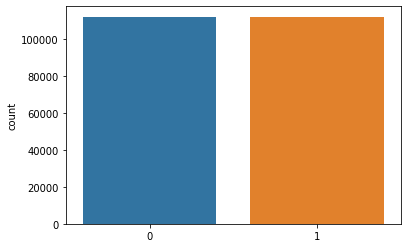

In [16]:
from imblearn.over_sampling import RandomOverSampler

#Code starts here

#Initialise the random over sampler object
ros = RandomOverSampler(random_state=0)

#Sample the train data using random over sampling method
X_sample_2, y_sample_2 = ros.fit_sample(X_train, Y_train)

# Using a countplot 
sns.countplot(y_sample_2)

#Initialising a logsitic regression model
model_ros = LogisticRegression()

#Fitting the model with train data
model_ros.fit(X_sample_2, y_sample_2)

#Making predictions of the train data
Y_pred=model_ros.predict(X_test)

# Calculating the necessary metrics
print("Accuracy = " , accuracy_score(Y_test, Y_pred))
print("Precision = " ,precision_score(Y_test, Y_pred))
print("Recall = " ,recall_score(Y_test, Y_pred))
print("F1 Score = " ,f1_score(Y_test, Y_pred))

#Finding the confusion matrix 
pd.crosstab(Y_pred, Y_test[target], rownames=['Predicted'], colnames=['Actual'])

#Code ends here

### So as you can observe from the above plot, oversampling has brought an equal balance in the distribution of classes in the target variable. Also the recall is much better compared to the vanilla model and Tomek undersampling

### Task 13 : Perform SMOTE on the train data and then fit a Logistic regression model on this undersampled data and then predict on the test data and calculate the precision, recall, accuracy, f1-score and the confusion matrix.

Accuracy: 0.7099666666666666
recall: 0.6114519427402862
precision: 0.13089635547772793
f1_score: 0.21563147931127738


Actual,0,1
Predicted,,
0,20103,760
1,7941,1196


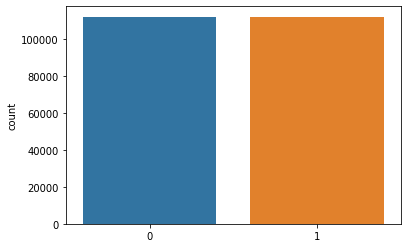

In [17]:
# Import package
from imblearn.over_sampling import SMOTE


#Code starts here

#Initialising a SMOTE object
smote = SMOTE(random_state=12,ratio=1.0)

#Sampling the data using SMOTE
X_sample_3, y_sample_3 = smote.fit_sample(X_train, Y_train)

# Using a countplot plot the distribution of y_sample_3
sns.countplot(y_sample_3)

#Initialising Logistic Regression model
model_smote = LogisticRegression()

#Fitting the model on train data
model_smote.fit(X_sample_3, y_sample_3)

#Making predictions on test data
Y_pred=model_smote.predict(X_test)

#Finding the accuracy score 
accuracy_smote=model_smote.score(X_test,Y_test)
print("Accuracy:",accuracy_smote)       


#Finding the recall score
recall_smote=recall_score(Y_test, Y_pred)
print ("recall:",recall_smote)

#Finding the precision score
precision_smote=precision_score(Y_test, Y_pred)
print ("precision:",precision_smote)

#Finding the f1 score
f1_smote=f1_score(Y_test, Y_pred)
print ("f1_score:", f1_smote)

#Finding the confusion matrix
pd.crosstab(Y_pred,Y_test[target], rownames=['Predicted'], colnames=['Actual'])
#Code ends here

### SMOTE performs on par with Random Oversampling giving almost the same recall ! 